In [1]:
import numpy as np
from alive_progress import alive_bar
import time
from math import sqrt, pi, exp
import functools
import scipy
from varname import nameof
import os
import re

# import algorithms (ULA, ALDI, NRALDI)
from utils.algorithms import * 
# import mog functions (density etc)
from utils.mog_functions import *
# import plot functions
from utils.plot_functions import *


## Test case "Mixture of Gaussians"  

## Run many experiments to average results 

In [2]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations #### TO CHANGE
d = 2 # dimension
tau = 1e-2 # step size

mean_init = np.asarray([2, 4])
cov_init = [[1, 0], [0, 2]]

# parameters of our algorithm
const = 1.5 


(2, 20)


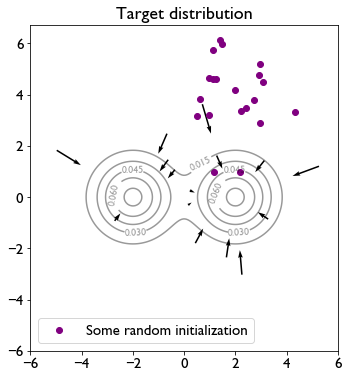

In [3]:
# dimension
d = 2


# parameters of the mixture 

sigma1, sigma2, gap = 1, 1, 4


# define (unnormalized) target density, potential, score (gradient log density)

target_unnorm_density = (lambda z : bimodal_distribution(z, gap, sigma1, sigma2))
# I had to add 1e-9 below to stabilize our scheme with inexact gradients
target_potential = (lambda z: -np.log(target_unnorm_density(z) + 1e-9))
gradient_log_target = (lambda z: gradient_of_log_bimodal_distribution(z,  gap, sigma1, sigma2))

# plot posterior

val = 6
xmin, xmax, ymin, ymax = -val, val, -val, val
nb_grid = 200
u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s) # each of the Ui's is of size (200, 200) (all X coordinates of points parallel to Y axis and reverse)
U = np.dstack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = target_unnorm_density(U) 

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z 
marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

fig, ax = plt.subplots(figsize = (10, 6))

DS = plt.contour(U0, U1, np.exp(-target_potential(U)), 5, alpha=0.4, colors="black")
plt.clabel(DS, inline=1, fontsize=10) # level sets of target


num_particles = 15
particles = np.random.normal(0, 2, size=(num_particles, d))
grad_particles = np.zeros_like(particles)
for i in range(num_particles):
        grad_particles[i] +=  gradient_log_target(particles[i,:])


x_pos = particles[:, 0]
y_pos = particles[:, 1]
x_direct = grad_particles[:, 0]
y_direct = grad_particles[:, 1]

ax.quiver(x_pos, y_pos, x_direct, y_direct, width = 0.005)
ax.set_title('Target distribution')
ax.set_aspect('equal')

# example of initialization of all algorithms
u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
print(u0.shape)
ax.scatter(u0[0, :], u0[1, :], color = "purple", label = 'Some random initialization')
ax.legend()

In [4]:
# number of experiments to run for the toy case/choice of hyperparameters
N_exp = 10


file_experiment = 'save_data/mog_gap_'+str(gap)+'_J_'+str(J)+'_Nsim_'+str(N_sim)+'_tau_'+str(tau)+'/'
print(file_experiment)


for j in range(N_exp):
    
    print()
    print("Experiment "+str(j))
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    #print(u0.shape)   #np.random.normal(0,1.0,(d,J)) 

    # ULA
    us_list_ULA = run_ULA_mog(gradient_log_target, N_sim, u0, tau)
    if not os.path.isdir(file_experiment+'/ULA'):
       os.makedirs(file_experiment+'/ULA')
    np.save(file_experiment+'ULA/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    # ALDI 
    if not os.path.isdir(file_experiment+'/ALDI'):
       os.makedirs(file_experiment+'/ALDI')
    us_list_ALDI = run_ALDI_with_gradient_mog(gradient_log_target, N_sim, u0, tau)
    np.save(file_experiment+'ALDI/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    
    # NRALDI 
    if not os.path.isdir(file_experiment+'/ALDINR'):
       os.makedirs(file_experiment+'/ALDINR')
    tau_ALDINR = tau
    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau_ALDINR, const) 
    np.save(file_experiment+'/ALDINR/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)
    


save_data/mog_gap_4_J_20_Nsim_1000_tau_0.01/

Experiment 0
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.5s (64.41/s
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.5s (64.66/s
on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.7450852676598558                                                        


on 0: /Users/annakorba/Desktop/nreks/utils/algorithms.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


on 500: iter                                                                    
on 500: 500                                                                     
on 500: lambda min                                                              
on 500: 6.019715856752578                                                       
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.9s (62.94/s

Experiment 1
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.5s (64.71/s
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.7s (63.82/s
on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.8423249558885972                                                        
on 500: iter                                                                    
on 500: 500

on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.6012937300431553                                                        
on 500: iter                                                                    
on 500: 500                                                                     
on 500: lambda min                                                              
on 500: 2.820917578814901                                                       
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 16.4s (60.90/s


## Compute some statistics over numerous random experiments on a toy case (we choose a toy case below e.g. a MOG with some gap and some initialization)

In [5]:
# Choose the experiment (Mixture of Gaussian with some gap and with some initialization)
toy_case = file_experiment

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

# Number of experiments for the toy case (on which results are averaged)
#N_exp = 0
list_expes_ALDINR = [f for f in listdir_nohidden(toy_case+'ALDINR/')]
N_exp = len(list_expes_ALDINR)
#name_first_file = list_expes_ALDINR[0] 

print('Number of experiments:', N_exp)

# dimension, number of particles, number of iterations, step size
name_first_file = os.listdir(toy_case +'ALDINR/')[1]
first_experiment_iterates = np.load(toy_case +'ALDINR/' + name_first_file)
d, J, N_sim = first_experiment_iterates.shape

tau = float(re.findall(re.escape('tau_')+"(.*)"+re.escape('_Exp'), name_first_file)[0])

print(d, J, N_sim, tau)

Number of experiments: 10
2 20 1000 0.01


In [6]:
# Create some statistics for experiments

# Means and covariances OVER PARTICLES at each time iteration and for each experiment

means_ULA_all  = np.zeros((d, N_sim, N_exp))
means_ALDI_all = np.zeros((d, N_sim, N_exp))
means_ALDINR_all = np.zeros((d, N_sim, N_exp))

covariances_ULA_all = np.zeros((d, d, N_sim, N_exp))
covariances_ALDI_all = np.zeros((d, d, N_sim, N_exp))
covariances_ALDINR_all = np.zeros((d, d, N_sim, N_exp))


for j in range(N_exp):

    # load data from experiment j
    us_list_ULA = np.load(toy_case + 'ULA/ULA_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')
    us_list_ALDI = np.load(toy_case + 'ALDI/ALDI_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')    
    us_list_ALDINR = np.load(toy_case +'ALDINR/ALDINR_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')
    
    #my_file = toy_case +'/ALDINR_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy'
    #const = re.findall(re.escape('c_')+"(.*)"+re.escape('_J'),my_file)[0]

    # compute means and covariances (at all iterations) over J particles for each experiment j   
    means_ULA_all[:, :, j] = np.mean(us_list_ULA, axis = 1)
    means_ALDI_all[:, :, j] = np.mean(us_list_ALDI, axis = 1)
    means_ALDINR_all[:, :, j] = np.mean(us_list_ALDINR, axis = 1)

    covariances_ULA_all[:, :, :, j] = compute_covariances(us_list_ULA)
    covariances_ALDI_all[:, :, :, j] = compute_covariances(us_list_ALDI)
    covariances_ALDINR_all[:, :, :, j] = compute_covariances(us_list_ALDINR)


# average over N_exp of the means of particles) - vectors of size (d, N_sim)

means_ULA_over_exp, std_ULA_over_exp = np.mean(means_ULA_all, axis = 2), np.std(means_ULA_all, axis = 2)
means_ALDI_over_exp, std_ALDI_over_exp = np.mean(means_ALDI_all, axis = 2), np.std(means_ALDI_all, axis = 2)
means_ALDINR_over_exp, std_ALDINR_over_exp = np.mean(means_ALDINR_all, axis = 2), np.std(means_ALDINR_all, axis = 2)

# average over N_exp of the covariances of the particles - vectors of size (d, d, N_sim)

covariances_ULA_over_exp = np.mean(covariances_ULA_all, axis = 3)
covariances_ALDI_over_exp = np.mean(covariances_ALDI_all, axis = 3)
covariances_ALDINR_over_exp = np.mean(covariances_ALDINR_all, axis = 3)


###  Plot the norm of empirical mean and norm of the empirical covariance matrix of particles

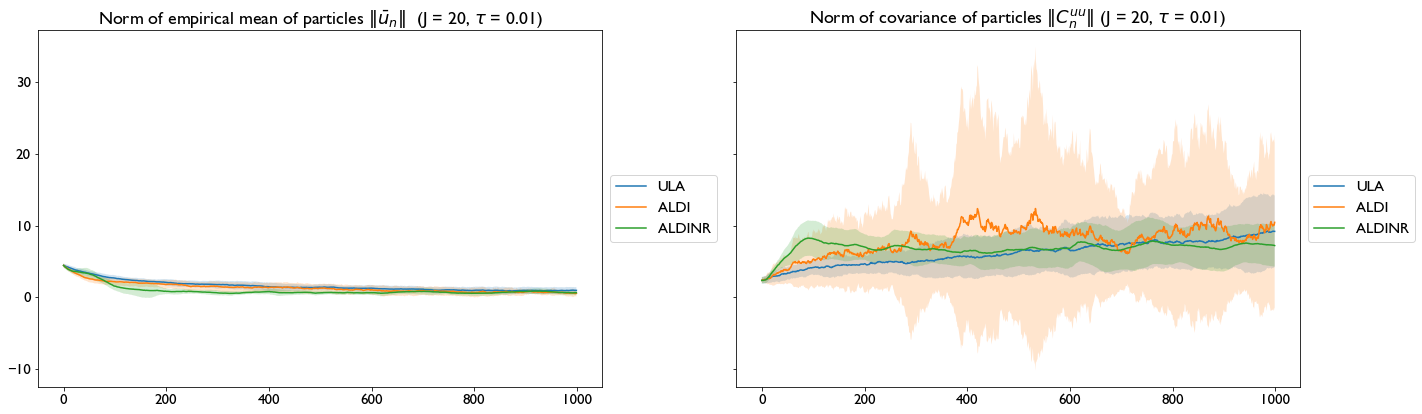

In [7]:
# the code below makes figure with subplots
# sharey = True means that we have the same scale for y axis for both subplots

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20, 6)) 

subplot_norm_means(means_ULA_all, 'ULA', J, tau, ax1)
subplot_norm_covariances(covariances_ULA_all, 'ULA', J, tau, ax2)

subplot_norm_means(means_ALDI_all, 'ALDI', J, tau, ax1)
subplot_norm_covariances(covariances_ALDI_all, 'ALDI', J, tau, ax2)

subplot_norm_means(means_ALDINR_all, 'ALDINR', J, tau, ax1)
subplot_norm_covariances(covariances_ALDINR_all, 'ALDINR', J, tau, ax2)

f.tight_layout()

### TODO : save fig

### Plot of the empirical mean of particles - first and second coordinate of the 2D vector

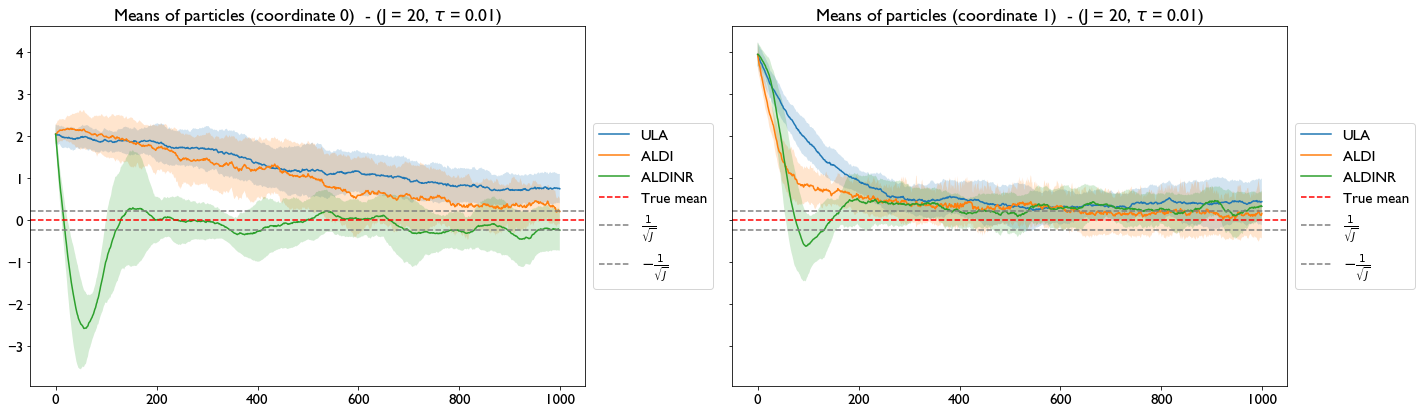

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20, 6)) 

subplot_mean_coordinate(means_ULA_all, 'ULA', J, tau, 0, ax1)
subplot_mean_coordinate(means_ULA_all, 'ULA', J, tau, 1, ax2)

subplot_mean_coordinate(means_ALDI_all, 'ALDI', J, tau, 0, ax1)
subplot_mean_coordinate(means_ALDI_all, 'ALDI', J, tau, 1, ax2)

subplot_mean_coordinate(means_ALDINR_all, 'ALDINR', J, tau, 0, ax1)
subplot_mean_coordinate(means_ALDINR_all, 'ALDINR', J, tau, 1, ax2)

# since we know the true mean here we can add:
for ax in (ax1, ax2):
    ax.axhline(y=0, color='r', linestyle='--', label ='True mean')
    ax.axhline(y = 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
    ax.axhline(y = -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

f.tight_layout()

### Plot ergodic average of the schemes (running average over previous iterations, i.e. means over particles are averaged over previous iterations) 

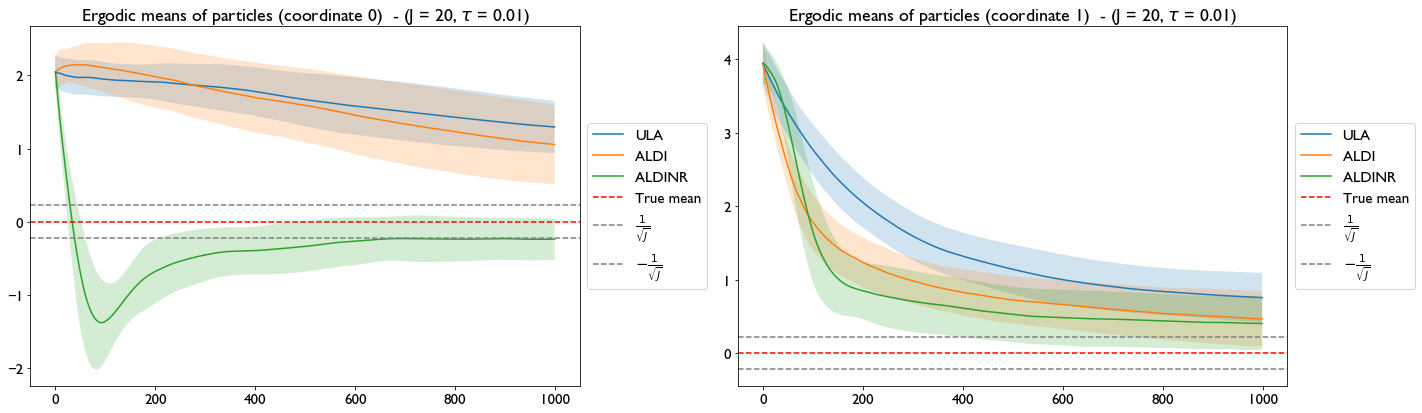

In [9]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize=(20, 6)) 
subplot_ergodic_mean_coordinate(means_ULA_all, 'ULA', J, tau, 0, ax1)
subplot_ergodic_mean_coordinate(means_ULA_all, 'ULA', J, tau, 1, ax2)

subplot_ergodic_mean_coordinate(means_ALDI_all, 'ALDI', J, tau, 0, ax1)
subplot_ergodic_mean_coordinate(means_ALDI_all, 'ALDI', J, tau, 1, ax2)

subplot_ergodic_mean_coordinate(means_ALDINR_all, 'ALDINR', J, tau, 0, ax1)
subplot_ergodic_mean_coordinate(means_ALDINR_all, 'ALDINR', J, tau, 1, ax2)


# since we know the true mean here we can add:
for ax in (ax1, ax2):
    ax.axhline(y=0, color='r', linestyle='--', label ='True mean')
    ax.axhline(y = 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
    ax.axhline(y = -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

f.tight_layout()


### Plot the coefficients of the covariance matrix of particles

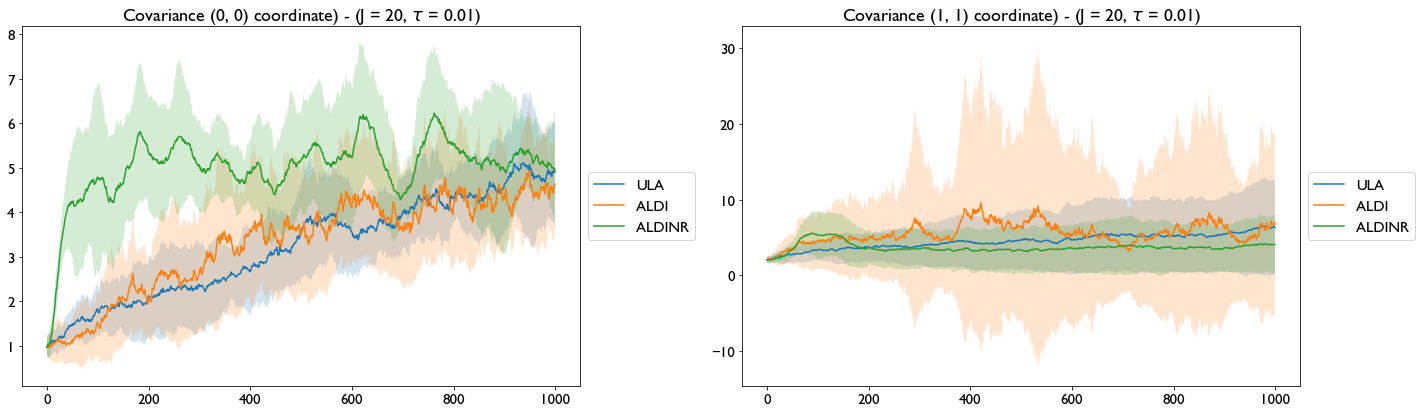

In [10]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize=(20, 6)) 

subplot_covariance_coordinate(covariances_ULA_all, 'ULA', J, tau, (0,0) , ax1)
subplot_covariance_coordinate(covariances_ULA_all, 'ULA', J, tau, (1,1) , ax2)

subplot_covariance_coordinate(covariances_ALDI_all, 'ALDI', J, tau, (0,0) , ax1)
subplot_covariance_coordinate(covariances_ALDI_all, 'ALDI', J, tau, (1,1) , ax2)

subplot_covariance_coordinate(covariances_ALDINR_all, 'ALDINR', J, tau, (0,0) , ax1)
subplot_covariance_coordinate(covariances_ALDINR_all, 'ALDINR', J, tau, (1,1) , ax2)

f.tight_layout()